In [1]:
#@title 2. 필수 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import re # (간단한 텍스트 정제용)

# TensorFlow / Keras (NLP 및 모델링)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, SpatialDropout1D, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn (전처리 및 평가)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [ ]:
#@title 3. [중요] 데이터 경로 및 하이퍼파라미터 설정

DATA_PATH = '/content/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv'  # <--- 훈련 CSV 파일 경로 (수정)

GLOVE_PATH = '/content/glove.6B.200d.txt' # <--- GloVe 파일 경로 (수정)
EMBEDDING_DIM = 100 # (Glove 파일의 차원과 일치해야 함. 예: 100d -> 100)

MAX_WORDS = 20000   # Tokenizer가 기억할 최대 단어 수 (어휘 사전 크기)
MAX_LEN = 250       # 문장의 최대 길이 (패딩 기준)


In [ ]:
#@title 4. 데이터 로드 및 텍스트 정제
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Data loaded successfully from: {DATA_PATH}")
except FileNotFoundError:
    print(f"Error: File not found at {DATA_PATH}")
    print("Please upload the CSV file and update the DATA_PATH variable.")
except Exception as e:
    print(f"An error occurred: {e}")

TEXT_COLUMN = 'Data' # <-- 실제 텍스트가 담긴 컬럼명으로 수정
TARGET_COLUMN = 'Accident Level' # <-- 실제 라벨이 담긴 컬럼명으로 수정

# Null 값 제거
df = df.dropna(subset=[TEXT_COLUMN, TARGET_COLUMN])

# 간단한 텍스트 정제 함수
def clean_text(text):
    text = text.lower() # 소문자 변환
    text = re.sub(r'[^a-z\s]', '', text) # 알파벳과 공백 외 문자 제거
    text = re.sub(r'\s+', ' ', text).strip() # 다중 공백 -> 단일 공백
    return text

if TEXT_COLUMN in df.columns:
    print("\nCleaning text data...")
    df[TEXT_COLUMN] = df[TEXT_COLUMN].astype(str).apply(clean_text)
    print("Text cleaning complete.")
else:
    print(f"Error: Text column '{TEXT_COLUMN}' not found. Please update the variable.")

print("\n--- Data Head After Cleaning ---")
print(df.head())

Data loaded successfully from: /content/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv

Cleaning text data...
Text cleaning complete.

--- Data Head After Cleaning ---
   Unnamed: 0 Data   Countries     Local Industry Sector Accident Level  \
0           0       Country_01  Local_01          Mining              I   
1           1       Country_02  Local_02          Mining              I   
2           2       Country_01  Local_03          Mining              I   
3           3       Country_01  Local_04          Mining              I   
4           4       Country_01  Local_04          Mining             IV   

  Potential Accident Level Genre Employee or Third Party        Critical Risk  \
0                       IV  Male             Third Party              Pressed   
1                       IV  Male                Employee  Pressurized Systems   
2                      III  Male    Third Party (Remote)         Manual Tools   
3                     

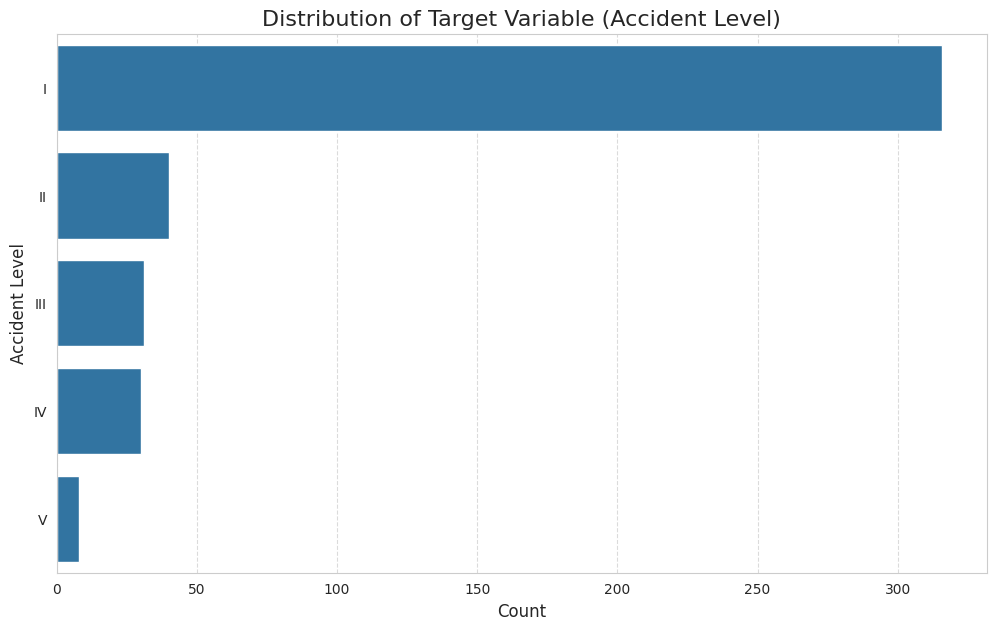

Analysis: Check for class imbalance. Severe imbalance may require techniques like oversampling (SMOTE) or class weights.


In [8]:
#@title 5. [EDA 보강] Target 분포(불균형) 확인 (영문 Plot)

plt.figure(figsize=(12, 7))
sns.countplot(data=df, y=TARGET_COLUMN, order=df[TARGET_COLUMN].value_counts().index)
plt.title('Distribution of Target Variable (Accident Level)', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Accident Level', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("Analysis: Check for class imbalance. Severe imbalance may require techniques like oversampling (SMOTE) or class weights.")

In [10]:
#@title 7. 텍스트 전처리 (Tokenizer, Padding, Label Encoding)

# 1. 라벨(y) 전처리 (String -> Integer -> One-Hot)
le = LabelEncoder()
y_encoded = le.fit_transform(df[TARGET_COLUMN])
N_CLASSES = len(le.classes_)
class_names_eng = le.classes_ # (시각화용 영문 라벨 이름)

# One-Hot Encoding (for Categorical Crossentropy)
y_one_hot = to_categorical(y_encoded, num_classes=N_CLASSES)

print(f"Found {N_CLASSES} unique classes: {class_names_eng}")

Found 5 unique classes: ['I' 'II' 'III' 'IV' 'V']


In [11]:
# 2. 텍스트(X) 전처리 (Tokenizer & Sequencing)
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df[TEXT_COLUMN])
sequences = tokenizer.texts_to_sequences(df[TEXT_COLUMN])

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

Found 0 unique tokens.


In [12]:
# 3. 패딩 (Padding)
# (모든 시퀀스를 동일한 길이(MAX_LEN)로 맞춥니다)
X_padded = pad_sequences(sequences, maxlen=MAX_LEN)

print(f"\nX (Padded Sequences) shape: {X_padded.shape}")
print(f"y (One-Hot Labels) shape: {y_one_hot.shape}")


X (Padded Sequences) shape: (425, 250)
y (One-Hot Labels) shape: (425, 5)


In [13]:
# 4. 데이터 분리 (Train / Test Split)
X_train, X_test, y_train, y_test = train_test_split(
    X_padded,
    y_one_hot,
    test_size=0.2,
    random_state=42,
    stratify=y_one_hot # 불균형 데이터이므로 Stratify 필수
)

print(f"\nTraining shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")


Training shape: (340, 250)
Testing shape: (85, 250)


In [14]:
#@title 8. [핵심] GloVe 임베딩 행렬(Matrix) 구축

print(f"Loading GloVe embeddings from: {GLOVE_PATH}")
embeddings_index = {} # {단어: 벡터} 맵
try:
    with open(GLOVE_PATH, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
except FileNotFoundError:
    print("!!! ERROR: GloVe file not found. Skipping embedding matrix creation. !!!")
    print("Please upload the GloVe file and update the GLOVE_PATH variable.")
    embeddings_index = {} # 빈 딕셔너리

print(f"Found {len(embeddings_index)} word vectors in GloVe file.")

Loading GloVe embeddings from: /content/glove.6B.200d.txt
Found 400000 word vectors in GloVe file.


In [15]:
# 2. Keras Tokenizer의 단어 사전을 기반으로 임베딩 행렬 생성
# (어휘 사전 크기 + 1 (0번 인덱스는 패딩용))
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue # MAX_WORDS (20000)를 초과하는 단어는 무시

    embedding_vector = embeddings_index.get(word) # GloVe 맵에서 단어 벡터 조회
    if embedding_vector is not None:
        # 단어가 GloVe 사전에 있으면 해당 벡터로 채움
        embedding_matrix[i] = embedding_vector
    # else: (단어가 없으면 0-vector로 유지됨)

print(f"\nEmbedding Matrix created with shape: {embedding_matrix.shape}")


Embedding Matrix created with shape: (20000, 100)


In [17]:
#@title 9. BiLSTM 모델 정의 (Embedding Layer 적용)

model = Sequential()

# 1. Embedding Layer (GloVe 가중치 동결)
model.add(Embedding(
    input_dim=MAX_WORDS,                 # 어휘 사전 크기 (Tokenizer 기준)
    output_dim=EMBEDDING_DIM,            # 임베딩 차원 (GloVe 기준)
    weights=[embedding_matrix],          # 사전 학습된 GloVe 가중치 적용
    input_length=MAX_LEN,                # 입력 시퀀스 길이
    trainable=False                      # [중요] GloVe 가중치를 훈련 중에 업데이트하지 않음 (동결)
))

# 2. BiLSTM 레이어 (원본 파일명 참조)
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))

# 3. Classifier (분류기)
model.add(Dense(128, activation='relu'))
model.add(Dense(N_CLASSES, activation='softmax')) # 다중 클래스 분류 (Softmax)

# 4. 컴파일
model.compile(
    loss='categorical_crossentropy', # 다중 클래스 분류 손실
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [19]:
#@title 10. 모델 학습 (Callbacks 적용)
# (원본 스니펫의 콜백 참조)

# ReduceLROnPlateau: 검증 손실이 개선되지 않으면 학습률을 동적으로 감소
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# EarlyStopping: 검증 손실이 5번 연속 개선되지 않으면 학습 조기 종료
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

print("\nStarting model training...")

# 원본 스니펫의 파라미터(epochs=100, batch_size=8)를 참고하되, 조기 종료를 사용합니다.
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=60, # (8은 너무 작을 수 있어 60로 상향 조정, Colab T4 기준)
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[rlrp, es]
)

print("\nModel training finished.")



Starting model training...
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7366 - loss: 1.4098 - val_accuracy: 0.7412 - val_loss: 1.4041 - learning_rate: 0.0010
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7732 - loss: 1.3899 - val_accuracy: 0.7412 - val_loss: 1.3990 - learning_rate: 0.0010
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7170 - loss: 1.4076 - val_accuracy: 0.7412 - val_loss: 1.3941 - learning_rate: 0.0010
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7343 - loss: 1.3958 - val_accuracy: 0.7412 - val_loss: 1.3890 - learning_rate: 0.0010
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7415 - loss: 1.3877 - val_accuracy: 0.7412 - val_loss: 1.3841 - learning_rate: 0.0010
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7272 - loss: 1.3892 - val_accuracy: 0.7412 - val_loss: 1.3792 - learning_rate: 0.0010
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7115 - loss: 1.3915 - val


Plotting training history...


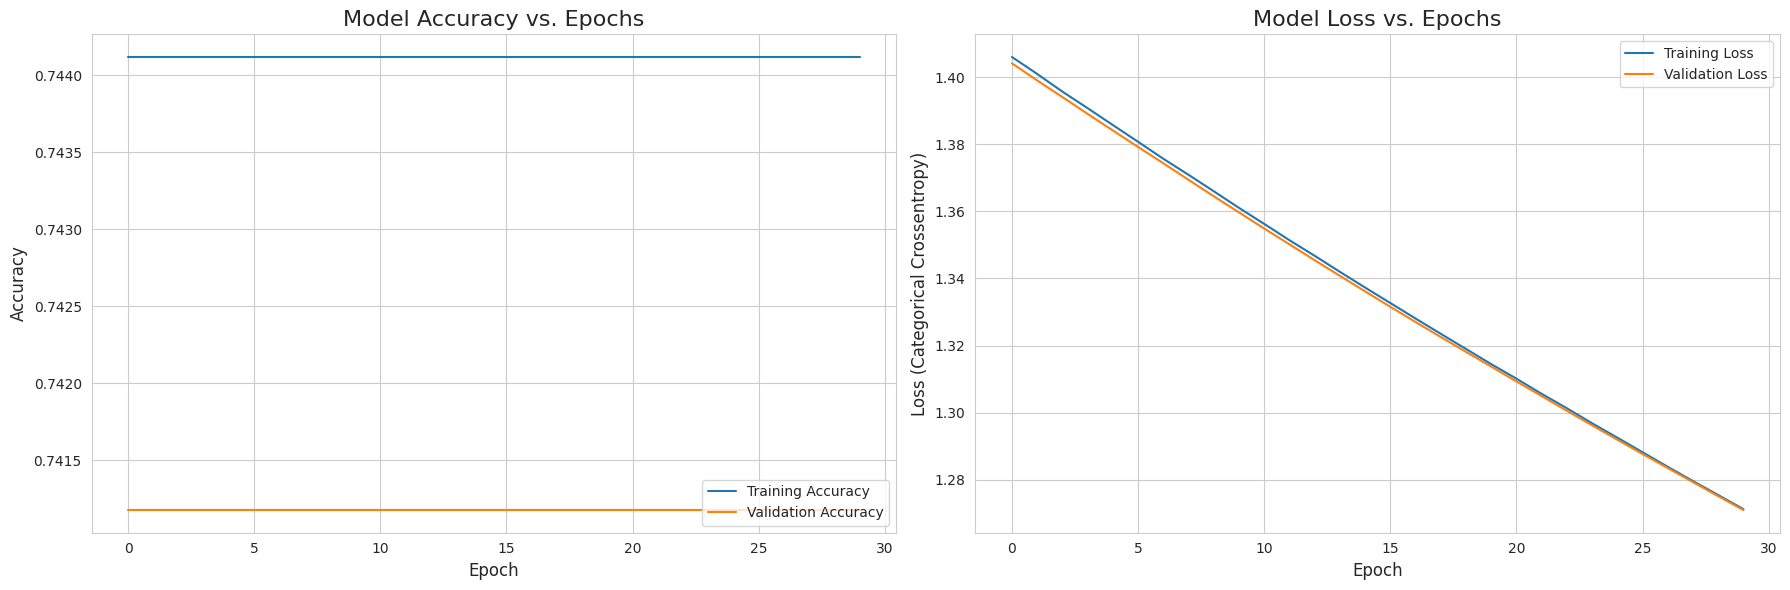

In [20]:
#@title 11. [결과 분석 보강] 학습 곡선 시각화 (Loss & Accuracy - 영문)

print("\nPlotting training history...")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Accuracy Plot (정확도)
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy vs. Epochs', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True)

# Loss Plot (손실)
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss vs. Epochs', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss (Categorical Crossentropy)', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [21]:
#@title 12. [결과 분석 보강] 최종 평가 (분류 리포트 및 혼동 행렬 - 영문)

print("\n--- Final Model Evaluation on Test Set ---")

# 1. 테스트셋 예측 (One-Hot 확률)
y_pred_probs = model.predict(X_test)

# 2. 확률을 클래스 인덱스로 변환 (np.argmax)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1) # One-Hot -> Index

# 3. 분류 리포트 (Classification Report)
print("\n[Classification Report (English)]")
# target_names는 LabelEncoder(Cell 7)에서 생성한 영문 클래스 이름 리스트 사용
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names_eng, zero_division=0))



--- Final Model Evaluation on Test Set ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 569ms/step

[Classification Report (English)]
              precision    recall  f1-score   support

           I       0.74      1.00      0.85        63
          II       0.00      0.00      0.00         8
         III       0.00      0.00      0.00         6
          IV       0.00      0.00      0.00         6
           V       0.00      0.00      0.00         2

    accuracy                           0.74        85
   macro avg       0.15      0.20      0.17        85
weighted avg       0.55      0.74      0.63        85




Plotting Confusion Matrix...


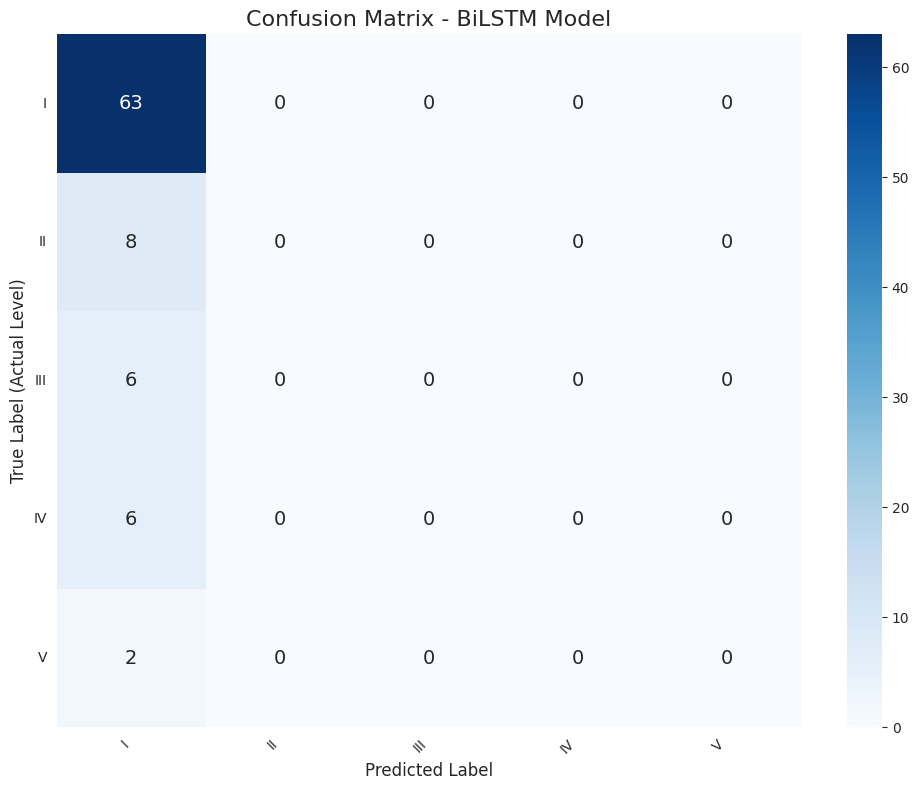

In [22]:
# 4. 혼동 행렬 (Confusion Matrix) 시각화
print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_eng,
            yticklabels=class_names_eng,
            annot_kws={"size": 14})

plt.title('Confusion Matrix - BiLSTM Model', fontsize=16)
plt.ylabel('True Label (Actual Level)', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()